In [24]:
import pdpbox as pdp

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler, MaxAbsScaler,  LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def get_poke_xy(dummies = True, label_encode = False, scaler = None, test_size = 0.3, random_state = 777, n_folds = 5):
    df = pd.read_csv("pokemon.zip", index_col = "Name")

    cat_cols = ["Type 1", "Type 2", "Generation"]
    num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
    target_col = "Legendary"
    drop_cols = ["#"]
    y_all = df[target_col].astype("int")
    
    X_all = df.drop(target_col , axis = 1)
    X_all.drop(drop_cols,axis=1, inplace = True)
    
    if label_encode:
        for c in cat_cols:
            try:
                X_all[c] = LabelEncoder().fit_transform(X_all[c].fillna("NaN"))
            except TypeError:
                print("could not encode: ", c)
    if dummies:
        X_all = X_all.drop(cat_cols, axis=1).join(pd.get_dummies(X_all[cat_cols].astype("category")))
    
    
    if scaler:
        sc = scaler()
        X_all[num_cols]  = sc.fit_transform(X_all[num_cols])
    
    kf = StratifiedKFold(n_splits = n_folds )
    folds = list(kf.split(X_all, y_all))
    
    return X_all, y_all, folds 
    

In [26]:
def train_model(X, y, folds, model = LogisticRegression, 
                model_params = {"penalty" :"l1", "solver" :"liblinear"}, 
                fit_params = None):
    
    colors = ["r","g", "b", "y", "c"]
    oof_preds = np.zeros(X.shape[0])
    scores = []
    models = []
    plt.subplots(figsize = (10, 10))
    #print(tgt, ":")
    plt.subplot(1, 1, 1)
    for i, (i_tr, i_te) in enumerate(folds):
        Xtr, Xte = X.iloc[i_tr], X.iloc[i_te]
        ytr, yte = y.iloc[i_tr], y.iloc[i_te]      
        if model_params:
            mdl = model(**model_params)
        else: mdl = model()
    
        if fit_params:
            mdl.fit(Xtr, ytr, **fit_params)
        else:
            mdl.fit(Xtr, ytr)
    
        models.append(mdl)
        preds =  mdl.predict_proba(Xte)[:, 1]
        oof_preds[i_te] = preds
        score = roc_auc_score(yte, preds)
        scores.append(score)
        fpr, tpr, threshold = roc_curve(yte, preds)
        plt.plot(fpr, tpr, color = colors[i] , label = f"fold:{i}, AUC:{score:.3f}")
        
    plt.title(f"{model.__name__} AUC:{np.mean(scores):.3f}")
    plt.legend(loc=4)
    plt.show()
    return oof_preds, scores, models

In [27]:
X_all, y_all, folds  = get_poke_xy(scaler = StandardScaler)

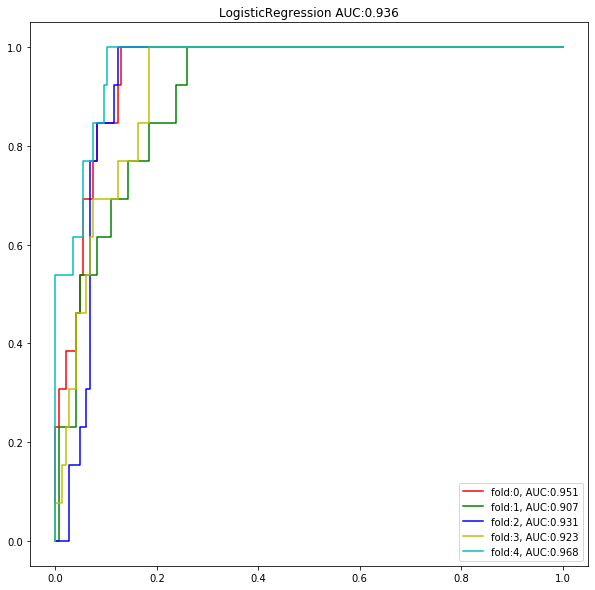

In [28]:
lr_preds, lr_scores, lr_models = train_model(X_all, y_all, folds)

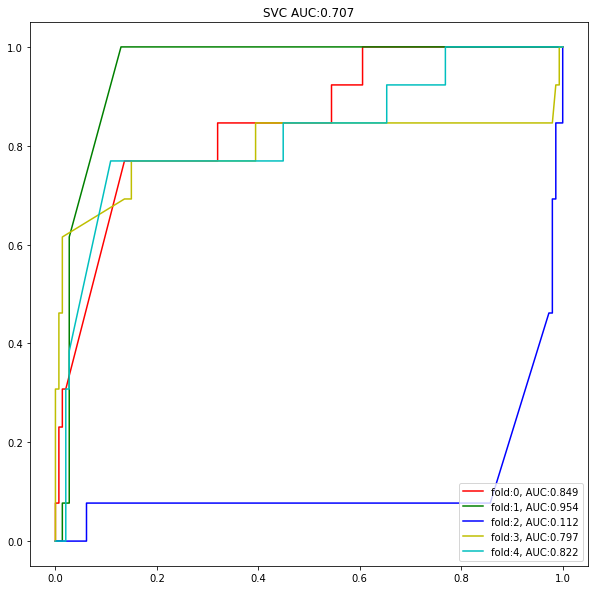

In [31]:
svm_preds, svm_scores, svm_model = train_model(X_all, y_all, folds, model = SVC, 
                                         model_params = {"probability" : True, "gamma":"auto"})

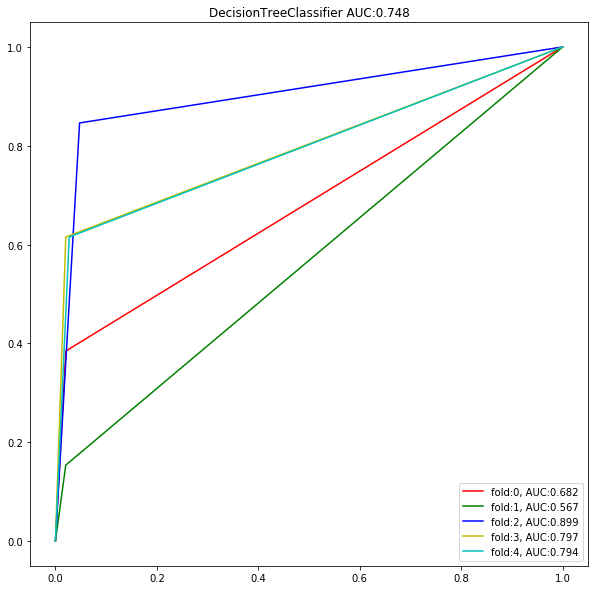

In [32]:
X_all, y_all, folds = get_poke_xy()

dt_preds, dt_scores, dt_models = train_model(X_all, y_all, folds,  model = DecisionTreeClassifier, model_params = None)

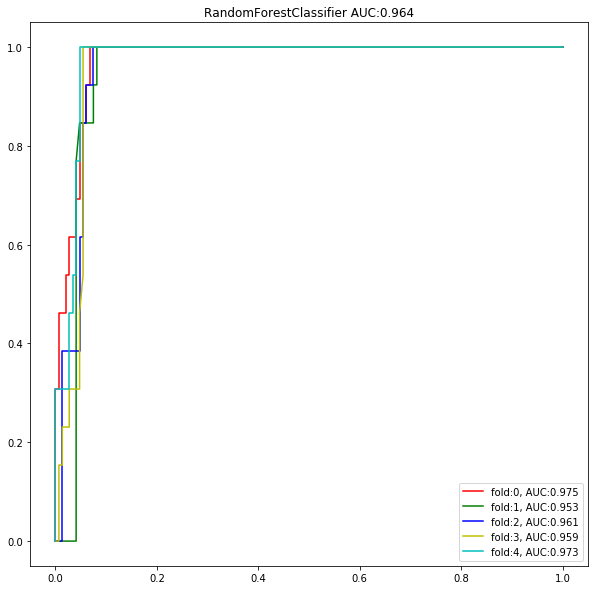

In [33]:
X_all, y_all, folds = get_poke_xy()

rf_preds, rf_scores, rf_models = train_model(X_all, y_all, folds, model = RandomForestClassifier, model_params = {"n_estimators":500})

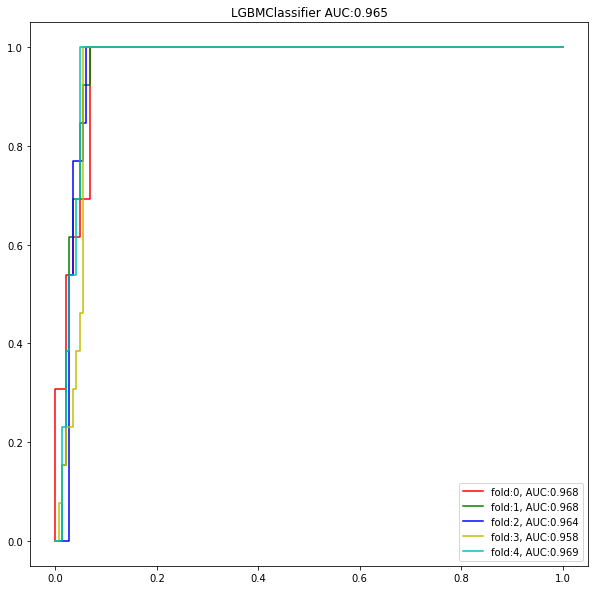

In [34]:
X_all, y_all, folds = get_poke_xy(dummies = False, label_encode = True)

lgb_preds, lgb_scores, lgb_models = train_model(X_all, y_all, folds, model = lgb.LGBMClassifier, 
                                         model_params = {"n_estimators" : 500,
                                                         "learning_rate" : 0.01})

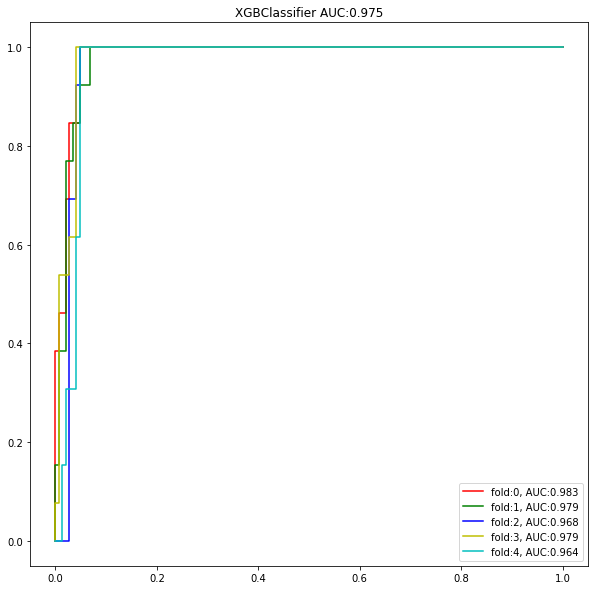

In [35]:
xgb_preds, xgb_scores, xgb_models = train_model(X_all, y_all, folds, model = xgb.XGBClassifier, 
                                         model_params = {"n_estimators" : 500,
                                                         "learning_rate" : 0.01})

In [36]:
X_all, y_all, folds = get_poke_xy(scaler = StandardScaler)

In [37]:
def train_nn(X, y, folds,  n_epochs = 20, batch_size = 32, seed = 777):
    colors = ["r","g", "b", "y", "c"]
    oof_preds = np.zeros(X.shape[0])
    scores = []
    models = []
    plt.subplots(figsize = (10, 10))
    #print(tgt, ":")
    plt.subplot(1, 1, 1)
    for i, (i_tr, i_te) in enumerate(folds):
        Xtr, Xte = X.iloc[i_tr], X.iloc[i_te]
        ytr, yte = y.iloc[i_tr], y.iloc[i_te]

        model = Sequential()
        model.add(Dense(64, input_dim=Xtr.shape[1], activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    
            # For a binary classification problem
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        model.fit(Xtr, ytr, epochs = n_epochs, batch_size = batch_size, verbose = 0)

        preds = model.predict_proba(Xte)[:, 0]
        score = roc_auc_score(yte, preds)
        oof_preds[i_te] = preds
        scores.append(score)
        models.append(model)
        fpr, tpr, threshold = roc_curve(yte, preds)
        plt.plot(fpr, tpr, color = colors[i] , label = f"fold:{i}, AUC:{score:.3f}")
        
    plt.title(f"MLP AUC:{np.mean(scores):.3f}")
    plt.legend(loc=4)
    plt.show()
    return oof_preds, scores, models

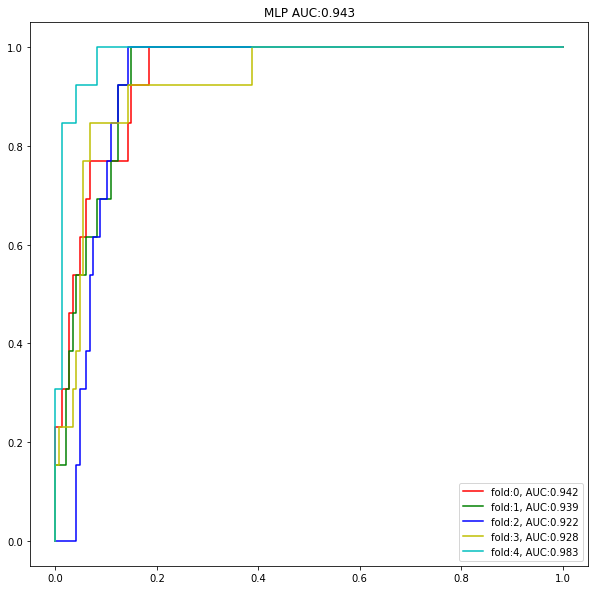

In [38]:
nn_preds, nn_scores, nn_models = train_nn(X_all, y_all, folds, n_epochs = 16, batch_size = 10)

In [39]:
from pdpbox import pdp, get_dataset, info_plots

In [40]:
poke_df = pd.read_csv("pokemon.zip", index_col = "Name").drop("#", axis=1)

In [41]:
poke_df["lr_pred"] = lr_preds
poke_df["dt_pred"] = dt_preds
poke_df["rf_pred"] = rf_preds
poke_df["svm_pred"] = svm_preds
poke_df["lgb_pred"] = lgb_preds
poke_df["xgb_pred"] = xgb_preds
poke_df["nn_pred"] = nn_preds


In [42]:
poke_df.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,lr_pred,dt_pred,rf_pred,svm_pred,lgb_pred,xgb_pred,nn_pred
Name,,,,,,,,,,,,,,,,,,
Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0.000041,0.0,0.000,0.076292,0.000547,0.004638,0.000000e+00
Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0.000705,0.0,0.000,0.075450,0.000539,0.004638,5.960464e-08
Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0.033143,0.0,0.008,0.076557,0.000899,0.004638,2.695560e-03
VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0.447642,0.0,0.406,0.076558,0.113191,0.136325,3.241577e-01
Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0.000036,0.0,0.000,0.061634,0.000547,0.004638,0.000000e+00


In [43]:
cat_cols = ["Type 1", "Type 2", "Generation"]

for c in cat_cols:
    poke_df[c] = LabelEncoder().fit_transform(poke_df[c].fillna("NaN"))

In [44]:
def target_plot(ftr, tgt):
    fig, axes, summary_df = info_plots.target_plot(
        df=poke_df, feature=ftr, feature_name=tgt, target=tgt
    )
    #return fig, axes, summary_df 

In [45]:
from ipywidgets import interact
import ipywidgets as widgets

In [46]:
ftr_cols = [i for i in poke_df.columns[~poke_df.columns.str.endswith("pred")] if i != "Legendary"]
tgt_cols = poke_df.columns[poke_df.columns.str.endswith("pred")].tolist() + ["Legendary"]

In [47]:
tgt_cols

['lr_pred',
 'dt_pred',
 'rf_pred',
 'svm_pred',
 'lgb_pred',
 'xgb_pred',
 'nn_pred',
 'Legendary']

# Target and prediction display

In [23]:
interact(target_plot, ftr = widgets.Dropdown(options = ftr_cols),
         tgt = widgets.Dropdown(options = tgt_cols),
        )

interactive(children=(Dropdown(description='ftr', options=('Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defen…

<function __main__.target_plot(ftr, tgt)>

## Actual predictions for SVM

In [48]:
X_all, y_all, folds  = get_poke_xy(scaler = StandardScaler)

def plot_svm_actuals(fold,ftr):
    fig, axes, summary_df = info_plots.actual_plot(
        model=svm_model[fold], predict_kwds={}, X=X_all.iloc[folds[fold][1],:], 
        feature=ftr, feature_name=ftr)
interact(plot_svm_actuals, fold = widgets.IntText(min=0, max = 4), ftr = widgets.Dropdown(options = X_all.columns.tolist()))

interactive(children=(IntText(value=0, description='fold'), Dropdown(description='ftr', options=('Total', 'HP'…

<function __main__.plot_svm_actuals(fold, ftr)>

In [ ]:

def plot_lr_actuals(fold,ftr):
    fig, axes, summary_df = info_plots.actual_plot(
        model=lr_models[fold], predict_kwds={}, X=X_all.iloc[folds[fold][1],:], 
        feature=ftr, feature_name=ftr)
interact(plot_lr_actuals, fold = widgets.IntText(min=0, max = 4), ftr = widgets.Dropdown(options = X_all.columns.tolist()))

In [ ]:
X_all, y_all, folds = get_poke_xy(dummies = False, label_encode = True)


def plot_lgb_actuals(fold,ftr):
    fig, axes, summary_df = info_plots.actual_plot(
        model=lgb_models[fold], predict_kwds={}, X=X_all.iloc[folds[fold][1],:], 
        feature=ftr, feature_name=ftr)
interact(plot_lgb_actuals, fold = widgets.IntText(min=0, max = 4), ftr = widgets.Dropdown(options = X_all.columns.tolist()))

In [ ]:
def plot_xgb_actuals(fold,ftr):
    fig, axes, summary_df = info_plots.actual_plot(
        model=xgb_models[fold], predict_kwds={}, X=X_all.iloc[folds[fold][1],:], 
        feature=ftr, feature_name=ftr)
interact(plot_lgb_actuals, fold = widgets.IntText(min=0, max = 4), ftr = widgets.Dropdown(options = X_all.columns.tolist()))

# Plotting PDP for isolated feature

In [49]:
X_all, y_all, folds  = get_poke_xy(scaler = StandardScaler)

In [50]:
ftr_list = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       ['Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon', 'Type 1_Electric',
       'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire', 'Type 1_Flying',
       'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground', 'Type 1_Ice',
       'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic', 'Type 1_Rock'],
       'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug', 'Type 2_Dark',
       ['Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy', 'Type 2_Fighting',
       'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost', 'Type 2_Grass',
       'Type 2_Ground', 'Type 2_Ice', 'Type 2_Normal', 'Type 2_Poison',
       'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel', 'Type 2_Water'],
       ['Generation_1', 'Generation_2', 'Generation_3', 'Generation_4',
       'Generation_5', 'Generation_6']]

In [51]:
def plot_svm_pdp(fold,ftr):
    p = pdp.pdp_isolate(
        model=svm_model[fold], predict_kwds={}, dataset=X_all, model_features= X_all.columns.tolist(),
        feature=ftr)
    fig, axes = pdp.pdp_plot(p, str(ftr), center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)
interact(plot_svm_pdp, fold = widgets.IntText(min=0, max = 4), ftr = widgets.Dropdown(options = ftr_list))

interactive(children=(IntText(value=0, description='fold'), Dropdown(description='ftr', options=('Total', 'HP'…

<function __main__.plot_svm_pdp(fold, ftr)>

In [52]:
def plot_nn_pdp(fold,ftr):
    p = pdp.pdp_isolate(
        model=nn_models[fold], predict_kwds={}, dataset=X_all, model_features= X_all.columns.tolist(),
        feature=ftr)
    fig, axes = pdp.pdp_plot(p, str(ftr), center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)
interact(plot_nn_pdp, fold = widgets.IntText(min=0, max = 4), ftr = widgets.Dropdown(options = ftr_list))

interactive(children=(IntText(value=0, description='fold'), Dropdown(description='ftr', options=('Total', 'HP'…

<function __main__.plot_nn_pdp(fold, ftr)>

In [53]:
ftr_cols = [i for i in poke_df.columns[~poke_df.columns.str.endswith("pred")] if i != "Legendary"]
tgt_cols = poke_df.columns[poke_df.columns.str.endswith("pred")].tolist() + ["Legendary"]

In [54]:
def plot_interact(ftr1, ftr2, tgt):
    fig, axes, summary_df = info_plots.target_plot_interact(df=poke_df, features=[ftr1, ftr2], feature_names=[ftr1, ftr2], target = tgt)

In [55]:
interact(plot_interact, ftr1 = widgets.Dropdown(options = ftr_cols, value = "Type 1"),
        ftr2 = widgets.Dropdown(options = ftr_cols, value = "Total"),
        tgt = widgets.Dropdown(options = tgt_cols))

interactive(children=(Dropdown(description='ftr1', options=('Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defe…

<function __main__.plot_interact(ftr1, ftr2, tgt)>

In [58]:
svm_cols = X_all.columns.tolist()

In [59]:
def plot_svm_pdp_interact(fold, ftr1, ftr2 ):
    inter1 = pdp.pdp_interact(
        model=svm_model[fold], dataset=X_all, model_features=X_all.columns.tolist(), features=[ftr1, ftr2]
    )


    fig, axes = pdp.pdp_interact_plot(
        pdp_interact_out=inter1, feature_names=[ftr1, ftr2], plot_type='grid', x_quantile=True, plot_pdp=True
    )

In [60]:
interact(plot_svm_pdp_interact, ftr1 = widgets.Dropdown(options = svm_cols, value = "Attack"),
        ftr2 = widgets.Dropdown(options = svm_cols, value="Speed"),
        fold  = widgets.IntText(min=0, max = 4))

interactive(children=(IntText(value=0, description='fold'), Dropdown(description='ftr1', index=2, options=('To…

<function __main__.plot_svm_pdp_interact(fold, ftr1, ftr2)>

In [61]:
interact(plot_svm_pdp_interact, ftr1 = widgets.Dropdown(options = ftr_list, value = "Attack"),
        ftr2 = widgets.Dropdown(options = ftr_list, value="Speed"),
        fold  = widgets.IntText(min=0, max = 4))

interactive(children=(IntText(value=0, description='fold'), Dropdown(description='ftr1', index=2, options=('To…

<function __main__.plot_svm_pdp_interact(fold, ftr1, ftr2)>